In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as tt

In [11]:
!curl https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.csv > data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 86845  100 86845    0     0   382k      0 --:--:-- --:--:-- --:--:--  382k


In [6]:
df = pd.read_csv('data.csv')
df['ds'] = pd.to_datetime(df['ds'])
df['y_scaled'] = df['y'] / df['y'].max()
df['t'] = (df['ds'] - df['ds'].min()) / (df['ds'].max() - df['ds'].min())


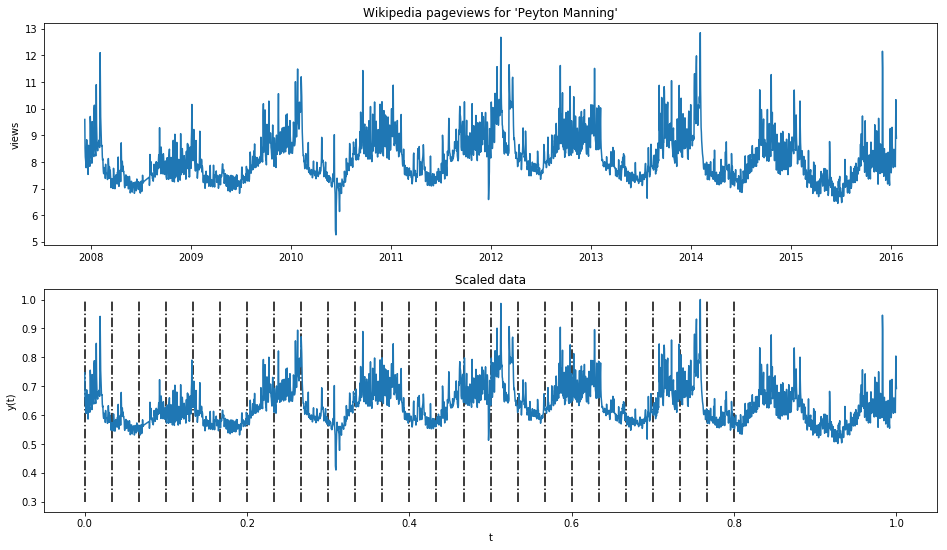

In [7]:
np.random.seed(25)

n_changepoints = 25
t = np.linspace(0, 1, 1000)

s = np.linspace(0, t[-1] * 0.8, n_changepoints)

# plt.figure(figsize=(16, 3))
# plt.xlabel('t')
# plt.yticks([])


fig = plt.figure(figsize=(16, 9))
fig.patch.set_facecolor('white')
plt.subplot(211)

plt.title("Wikipedia pageviews for 'Peyton Manning'")
plt.ylabel('views')
plt.plot(df['ds'], df['y'])

plt.subplot(212)
plt.title('Scaled data')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.plot(df['t'], df['y_scaled'])
plt.vlines(s, 0.3, df['t'].max(), linestyle='-.')

In [13]:
def det_dot(a, b):
    """
    The theano dot product and NUTS sampler don't work with large matrices?
    
    :param a: (np matrix)
    :param b: (theano vector)
    """
    return (a * b[None, :]).sum(axis=-1)

def trend_model(m, t, n_changepoints=25, changepoints_prior_scale=0.05, 
                growth_prior_scale=5, changepoint_range=0.8):
    """
    The piecewise linear trend with changepoint implementation in PyMC3.
    :param m: (pm.Model)
    :param t: (np.array) MinMax scaled time.
    :param n_changepoints: (int) The number of changepoints to model.
    :param changepoint_prior_scale: (flt/ None) The scale of the Laplace prior on the delta vector.
                                    If None, a hierarchical prior is set.
    :param growth_prior_scale: (flt) The standard deviation of the prior on the growth.
    :param changepoint_range: (flt) Proportion of history in which trend changepoints will be estimated. 
    :return g, A, s: (tt.vector, np.array, tt.vector)
    """
    s = np.linspace(0, changepoint_range * np.max(t), n_changepoints + 1)[1:]
    
    # * 1 casts the boolean to integers
    A = (t[:, None] > s) * 1

    with m:
        # initial growth
        k = pm.Normal('k', 0 , growth_prior_scale)
        
        if changepoints_prior_scale is None:
            changepoints_prior_scale = pm.Exponential('tau', 1.5)
        
        # rate of change
        delta = pm.Laplace('delta', 0, changepoints_prior_scale, shape=n_changepoints)
        # offset
        m = pm.Normal('m', 0, 5)
        gamma = -s * delta
        
        g = (k + det_dot(A, delta)) * t + (m + det_dot(A, gamma))
    return g, A, s



with pm.Model() as m:
    y, A, s = trend_model(m, df['t'])
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    pm.Normal('obs', 
                 mu=y,
                 sd=sigma,
                 observed=df['y_scaled'])
    aprox_1 = pm.find_MAP()
    

with pm.Model() as m:
    y, A, s = trend_model(m, df['t'], changepoints_prior_scale=0.5)
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    pm.Normal('obs', 
                 mu=y,
                 sd=sigma,
                 observed=df['y_scaled'])
    aprox_2 = pm.find_MAP()



logp = 4,021.6, ||grad|| = 139.89: 100%|██████████| 253/253 [00:00<00:00, 795.53it/s] 
logp = 4,507.7, ||grad|| = 3.9738: 100%|██████████| 1230/1230 [00:01<00:00, 735.55it/s]


([], <a list of 0 Text yticklabel objects>)

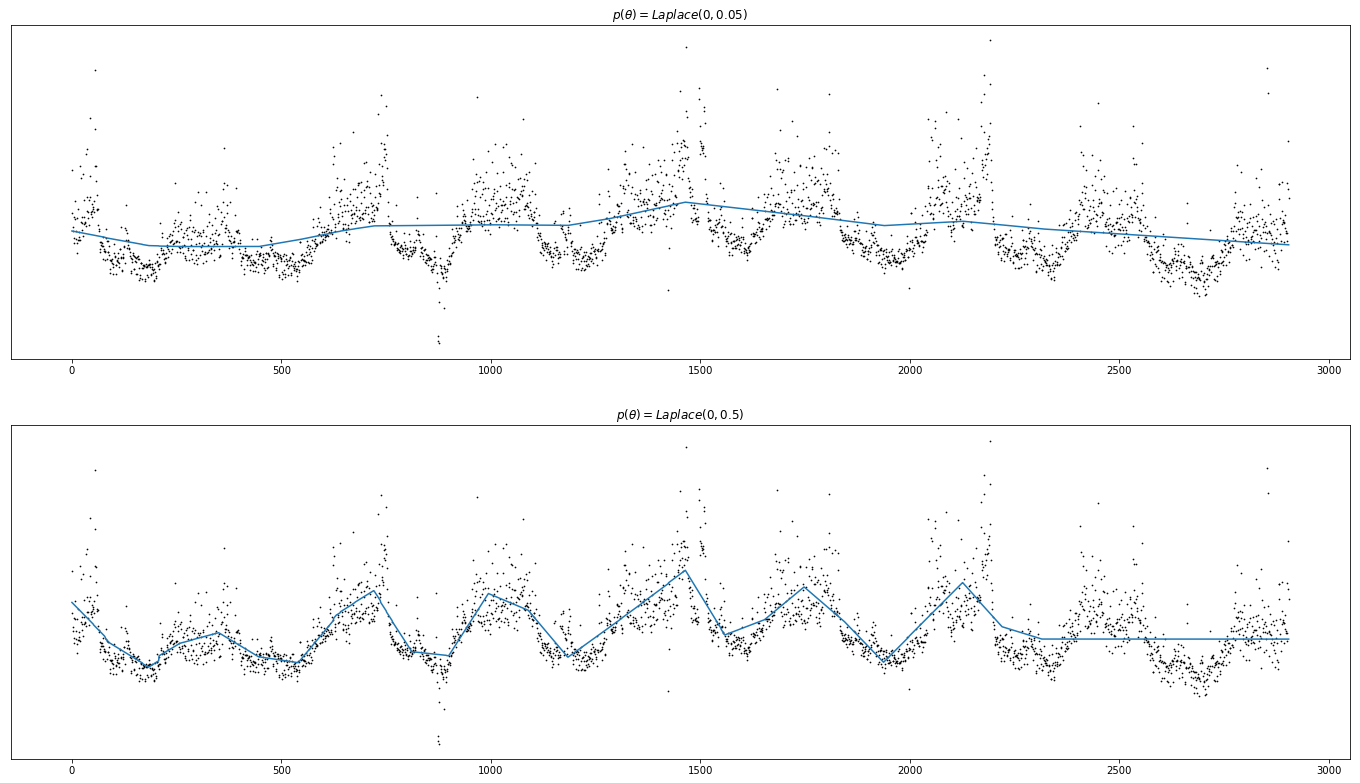

In [29]:

# Determine g, based on the parameters
def det_trend(k, m, delta, t, s, A):
    return (k + np.dot(A, delta)) * t + (m + np.dot(A, (-s * delta)))

# run function and rescale to original scale
g_1 = det_trend(aprox_1['k'], aprox_1['m'], aprox_1['delta'], df['t'], s, A) * df['y'].max()
g_2 = det_trend(aprox_2['k'], aprox_2['m'], aprox_2['delta'], df['t'], s, A) * df['y'].max()

plt.figure(figsize=(16 * 1.5, 9 * 1.5))
fig.patch.set_facecolor('white')

plt.subplot(211)
plt.title('$p(\\theta) = Laplace(0, 0.05)$')
plt.plot(g_1)
plt.scatter(np.arange(df.shape[0]), df.y, s=0.5, color='black')
plt.yticks([])


plt.subplot(212)
plt.title('$p(\\theta) = Laplace(0, 0.5)$')
plt.plot(g_2)
plt.scatter(np.arange(df.shape[0]), df.y, s=0.5, color='black')
plt.yticks([])
